<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Seq2Seq-and-Transformer-for-Summarization-SAMSUM-Dataset/Abstractive_Summarization_SAMSUM_DS_S2S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries Installation

In [1]:
!pip install -q datasets tensorflow numpy rouge-score

  Preparing metadata (setup.py) ... done


# Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import re
import string
import time
import matplotlib.pyplot as plt
from datasets import load_dataset

from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense,
    Bidirectional, Concatenate, Dropout,
    TextVectorization, LayerNormalization # Added LayerNormalization here
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load & Analyze Dataset

In [3]:
try:
    print("Loading SAMSum dataset...")
    # We will use the entire training set, which is manageable
    raw_dataset =  load_dataset("knkarthick/samsum")
    print(f"Successfully loaded {len(raw_dataset)} samples.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

# Extract train/test/val dataset from raw_dataset
train_ds = raw_dataset['train']
val_ds = raw_dataset['validation']
test_ds = raw_dataset['test']

# Extract "dialogue" and "summary" from each split
train_documents = [item['dialogue'] for item in train_ds]
train_summaries = [item['summary'] for item in train_ds]
val_documents = [item['dialogue'] for item in val_ds]
val_summaries = [item['summary'] for item in val_ds]
test_documents = [item['dialogue'] for item in test_ds]
test_summaries = [item['summary'] for item in test_ds]

print(f"Number of training samples: {len(train_documents)}")
print(f"Number of validation samples: {len(val_documents)}")
print(f"Number of test samples: {len(test_documents)}")

Loading SAMSum dataset...


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14731 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Successfully loaded 3 samples.
Number of training samples: 14731
Number of validation samples: 818
Number of test samples: 819


**Analyze Sequence Lengths**

In [4]:
documents_lengths = [len(doc.split()) for doc in train_documents]
summaries_lengths = [len(doc.split()) for doc in train_summaries]

documents_length_mean = np.mean(documents_lengths)
summaries_lengths_mean = np.mean(summaries_lengths)

print(f"Document Length Mean: {documents_length_mean}")
print(f"Summaries Length Mean: {summaries_lengths_mean}\n\n")

print("Document (Dialogue) Lengths:")
for percentile in [90, 95, 98, 99]:
    print(f"{percentile}% of documents are shorter than: {np.percentile(documents_lengths, percentile):.0f}")

print("\nSummaries Lengths:")
for percentile in [90, 95, 98, 99]:
    print(f"{percentile}% of summaries are shorter than: {np.percentile(summaries_lengths, percentile):.0f} words")

Document Length Mean: 93.79274998302898
Summaries Length Mean: 20.318444097481503


Document (Dialogue) Lengths:
90% of documents are shorter than: 191
95% of documents are shorter than: 237
98% of documents are shorter than: 301
99% of documents are shorter than: 351

Summaries Lengths:
90% of summaries are shorter than: 37 words
95% of summaries are shorter than: 43 words
98% of summaries are shorter than: 50 words
99% of summaries are shorter than: 53 words


**Percentiles Plot**

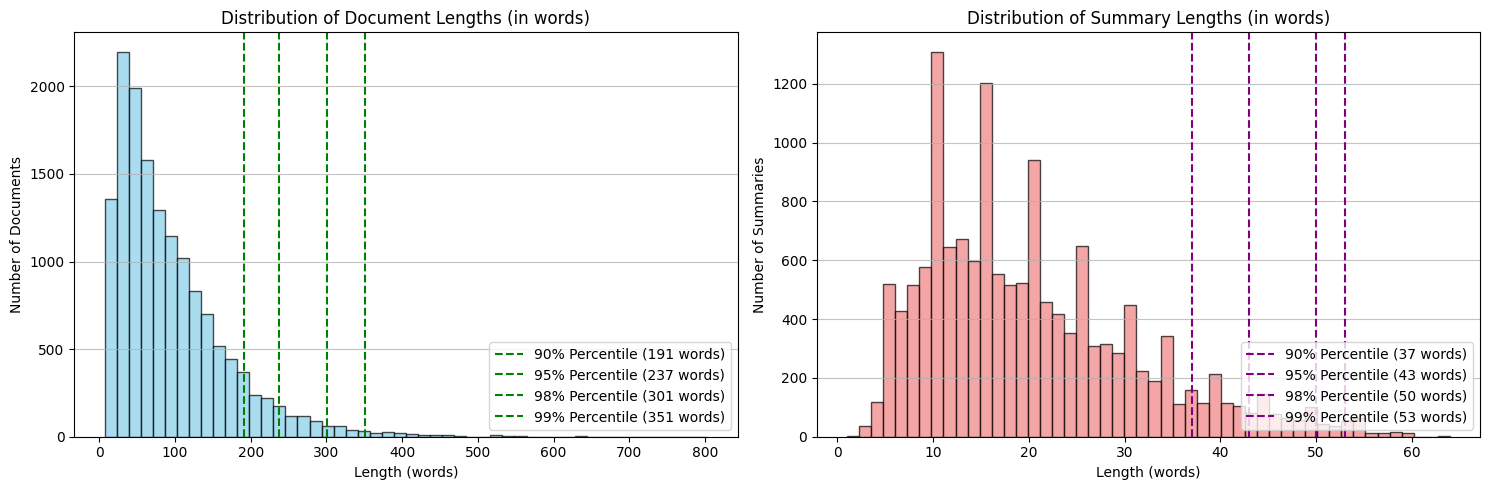

In [5]:
plt.figure(figsize=(15, 5))

# Plot for Document Lengths
plt.subplot(1, 2, 1)
plt.hist(documents_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Document Lengths (in words)')
plt.xlabel('Length (words)')
plt.ylabel('Number of Documents')

for percentile in [90, 95, 98, 99]:
    value = np.percentile(documents_lengths, percentile)
    plt.axvline(value, color='green', linestyle='--', label=f'{percentile}% Percentile ({value:.0f} words)') # Changed color to green
plt.legend(loc="lower right")
plt.grid(axis='y', alpha=0.75)

# Plot for Summary Lengths
plt.subplot(1, 2, 2)
plt.hist(summaries_lengths, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
plt.title('Distribution of Summary Lengths (in words)')
plt.xlabel('Length (words)')
plt.ylabel('Number of Summaries')

for percentile in [90, 95, 98, 99]:
    value = np.percentile(summaries_lengths, percentile)
    plt.axvline(value, color='purple', linestyle='--', label=f'{percentile}% Percentile ({value:.0f} words)') # Changed color to purple
plt.legend(loc="lower right")
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

**Set Max Len Values**

In [6]:
MAX_TEXT_LEN = 200
MAX_SUMMARY_LEN = 50

# Data Preprocessing & Cleaning

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"(\\r|\\n)", " ", text) # Remove newline characters
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\']', '', text) # Keep essential punctuation
    return text.strip()

# Clean all text splits
train_documents_cleaned = [clean_text(doc) for doc in train_documents]
train_summaries_cleaned = [clean_text(summary) for summary in train_summaries]

val_documents_cleaned = [clean_text(doc) for doc in val_documents]
val_summaries_cleaned = [clean_text(summary) for summary in val_summaries]

test_documents_cleaned = [clean_text(doc) for doc in test_documents]
test_summaries_cleaned = [clean_text(summary) for summary in test_summaries]

**Tokenization & Padding**

In [8]:
VOCAB_SIZE = 20_000

source_vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_TEXT_LEN,
    name="source_vectorization"
)

target_vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SUMMARY_LEN + 2, # +2 for start and end tokens
    name="target_vectorization",
    standardize=None # Our clean_text function already handles standardization
)

# Manually add start and end tokens to summaries before adapting
train_summaries_with_tokens = ['s ' + summary + ' </s>' for summary in train_summaries_cleaned]
val_summaries_with_tokens = ['s ' + summary + ' </s>' for summary in val_summaries_cleaned]
test_summaries_with_tokens = ['s ' + summary + ' </s>' for summary in test_summaries_cleaned]

# Adapt
source_vectorization.adapt(train_documents_cleaned)
target_vectorization.adapt(train_summaries_with_tokens)

print(f"Source Vectorization Vocabulary Size: {source_vectorization.vocabulary_size()}")
print(f"Target Vectorization Vocabulary Size: {target_vectorization.vocabulary_size()}")

Source Vectorization Vocabulary Size: 20000
Target Vectorization Vocabulary Size: 20000


# `tf.data` Pipeline

In [9]:
BATCH_SIZE = 64

def create_tf_dataset(documents, summaries_with_tokens):
    dataset = tf.data.Dataset.from_tensor_slices((documents, summaries_with_tokens))
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

    def format_data(docs, sums_with_tokens):
        encoder_input = source_vectorization(docs)
        decoder_full_seq = target_vectorization(sums_with_tokens)

        decoder_input = decoder_full_seq[:, :-1] # Exclude the actual end token from input
        decoder_output = decoder_full_seq[:, 1:]  # Exclude the start token from output

        return (encoder_input, decoder_input), decoder_output

    dataset = dataset.map(format_data, num_parallel_calls=tf.data.AUTOTUNE) \
                            .prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create the training and validation datasets using summaries_with_tokens
train_tf_dataset = create_tf_dataset(train_documents_cleaned, train_summaries_with_tokens)
val_tf_dataset = create_tf_dataset(val_documents_cleaned, val_summaries_with_tokens)

# GloVe Embeddings

In [10]:
# Download
!wget http://nlp.stanford.edu/data/glove.6B.zip -O glove.6B.zip
!unzip -q glove.6B.zip

--2025-11-14 16:25:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-14 16:25:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-14 16:25:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [11]:
EMBEDDING_DIM = 100
glove_path = "glove.6B.100d.txt"
embeddings_index = {}

with open(glove_path, encoding="utf-8") as f:
    for line in f:
        word, *coefs = line.split()
        embeddings_index[word] = np.asarray(coefs, dtype="float32")
print(f"Found {len(embeddings_index)} word vectors in GloVe\n")

# Creating Embedding Matrix for Source Vocab
source_vocab = source_vectorization.get_vocabulary()
print(f"Source Vocabulary Size: {len(source_vocab)}")
embedding_matrix_source = np.zeros((len(source_vocab), EMBEDDING_DIM))
for i, word in enumerate(source_vocab):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_source[i] = embedding_vector

# Creating Embedding Matrix for Target Vocab
target_vocab = target_vectorization.get_vocabulary()
print(f"Target Vocabulary Size: {len(target_vocab)}")
embedding_matrix_target = np.zeros((len(target_vocab), EMBEDDING_DIM))
for i, word in enumerate(target_vocab):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_target[i] = embedding_vector

print("Embedding matrices created...\n")

Found 400000 word vectors in GloVe

Source Vocabulary Size: 20000
Target Vocabulary Size: 20000
Embedding matrices created...



**Analyze Tokens Included in GloVe and Misses**

In [12]:
def analyze_glove_coverage(vocab, embedding_index, name):
    hits = 0
    misses = 0
    missed_words = []

    for i, word in enumerate(vocab):
        if i == 0 or i == 1: # Skip special tokens like '' and '[UNK]'
            continue
        if word in embedding_index:
            hits += 1
        else:
            misses += 1
            missed_words.append(word)

    print(f"GloVe Coverage for {name} Vocabulary")
    print(f"Total words in vocabulary: {len(vocab) - 2}") # Excluding special tokens
    print(f"Words found in GloVe: {hits}")
    print(f"Words not found in GloVe: {misses}")
    print(f"Percentage of words found: {hits / (len(vocab) - 2) * 100:.2f}%")
    if missed_words:
        print("\nTop 20 missed words:")
        print(missed_words[:20])
    print("------------------------------------------\n")

analyze_glove_coverage(source_vocab, embeddings_index, "Source")
analyze_glove_coverage(target_vocab, embeddings_index, "Target")

GloVe Coverage for Source Vocabulary
Total words in vocabulary: 19998
Words found in GloVe: 17589
Words not found in GloVe: 2409
Percentage of words found: 87.95%

Top 20 missed words:
[np.str_('filephoto'), np.str_('filegif'), np.str_('fileother'), np.str_('hahaha'), np.str_('youve'), np.str_('filevideo'), np.str_('itll'), np.str_('idk'), np.str_('hahah'), np.str_('shouldnt'), np.str_('hahahaha'), np.str_('theyll'), np.str_('cmon'), np.str_('everythings'), np.str_('bday'), np.str_('hahahah'), np.str_('theyve'), np.str_('srsly'), np.str_('tbh'), np.str_('photofile')]
------------------------------------------

GloVe Coverage for Target Vocabulary
Total words in vocabulary: 19998
Words found in GloVe: 11018
Words not found in GloVe: 8980
Percentage of words found: 55.10%

Top 20 missed words:
[np.str_('</s>'), np.str_("doesn't"), np.str_('it.'), np.str_('tomorrow.'), np.str_("it's"), np.str_("can't"), np.str_("she's"), np.str_('her.'), np.str_('today.'), np.str_("he's"), np.str_("didn't

# Model Definition

In [13]:
LATENT_DIM = 256
DROPOUT_RATE = 0.5
VOCAB_SIZE_SOURCE = source_vectorization.vocabulary_size()
VOCAB_SIZE_TARGET = target_vectorization.vocabulary_size()

# ENCODER
encoder_inputs = Input(
    shape=(MAX_TEXT_LEN,),
    dtype="int64",
    name="encoder_inputs"
)
enc_embedding = Embedding(
    VOCAB_SIZE_SOURCE, EMBEDDING_DIM,
    weights=[embedding_matrix_source],
    trainable=False,
    mask_zero=True,
    name="encoder_embedding"
)(encoder_inputs)

encoder_lstm1 = Bidirectional(
    LSTM(LATENT_DIM,
         return_sequences=True,
         return_state=True,
         dropout=DROPOUT_RATE),
    name="encoder_lstm1"
)

encoder_outputs1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_embedding)

encoder_lstm2 = Bidirectional(
    LSTM(
        LATENT_DIM,
        return_state=True,
        dropout=DROPOUT_RATE
    ),
    name="encoder_lstm2"
)
_, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_outputs1)

state_h_final = Concatenate()([forward_h2, backward_h2])
state_c_final = Concatenate()([forward_c2, backward_c2])
encoder_states = [state_h_final, state_c_final]


# DECODER
decoder_inputs = Input(
    shape=(None,),
    dtype="int64",
    name="decoder_inputs"
)
dec_embedding_layer = Embedding(
    VOCAB_SIZE_TARGET, EMBEDDING_DIM,
    weights=[embedding_matrix_target],
    trainable=False,
    mask_zero=True,
    name="decoder_embedding"
)
dec_embedding = dec_embedding_layer(decoder_inputs)

decoder_lstm1 = LSTM(
    LATENT_DIM * 2,
    return_sequences=True,
    return_state=True,
    dropout=DROPOUT_RATE,
    name="decoder_lstm1"
)

decoder_outputs1, _, _ = decoder_lstm1(dec_embedding, initial_state=encoder_states)

decoder_lstm2 = LSTM(
    LATENT_DIM * 2,
    return_sequences=True,
    return_state=True,
    dropout=DROPOUT_RATE,
    name="decoder_lstm2"
)
decoder_outputs2, _, _ = decoder_lstm2(decoder_outputs1)

# OUTPUT
decoder_dense = Dense(VOCAB_SIZE_TARGET,
                       activation="softmax",
                       name="output_layer")
decoder_outputs = decoder_dense(decoder_outputs2)

# Construct Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 200, 100)  │  2,000,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm1       │ [(None, 200,      │    731,136 │ encoder_embeddin… │
│ (Bidirectional)     │ 512), (None,      │            │ not_equal[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm2       │ [(None, 512),     │  1,574,912 │ encoder_lstm1[0]… │
│ (Bidirectional)     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 100) │  2,000,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ encoder_lstm2[0]… │
│ (Concatenate)       │                   │            │ encoder_lstm2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ encoder_lstm2[0]… │
│ (Concatenate)       │                   │            │ encoder_lstm2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm1       │ [(None, None,     │  1,255,424 │ decoder_embeddin… │
│ (LSTM)              │ 512), (None,      │            │ concatenate[0][0… │
│                     │ 512), (None,      │            │ concatenate_1[0]… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None)      │          0 │ decoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm2       │ [(None, None,     │  2,099,200 │ decoder_lstm1[0]… │
│ (LSTM)              │ 512), (None,      │            │ not_equal_1[0][0] │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, None,      │ 10,260,000 │ decoder_lstm2[0]… │
│ (Dense)             │ 20000)            │            │                 

 Total params: 19,920,672 (75.99 MB)

 Trainable params: 15,920,672 (60.73 MB)

 Non-trainable params: 4,000,000 (15.26 MB)

# Train the Model

In [14]:
callbacks = [
    EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(
        filepath='best_samsum_model_modern.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

EPOCHS = 50

history = model.fit(
    train_tf_dataset,
    epochs=EPOCHS,
    validation_data=val_tf_dataset,
    callbacks=callbacks
)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 70s 262ms/step - accuracy: 0.0477 - loss: 7.2390 - val_accuracy: 0.0324 - val_loss: 6.3521 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 77s 257ms/step - accuracy: 0.0467 - loss: 6.5296 - val_accuracy: 0.0646 - val_loss: 5.9527 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 59s 256ms/step - accuracy: 0.0656 - loss: 6.1634 - val_accuracy: 0.0713 - val_loss: 5.7132 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 59s 257ms/step - accuracy: 0.0716 - loss: 5.9419 - val_accuracy: 0.0745 - val_loss: 5.5835 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 59s 256ms/step - accuracy: 0.0744 - loss: 5.8062 - val_accuracy: 0.0781 - val_loss: 5.4785 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 60s 258ms/step - accuracy: 0.0768 - loss: 5.7032 - val_accuracy: 0.0807 - val_loss: 5.3872 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 60s 258ms/step - accuracy: 0.0

# Inference Model

In [15]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

# Decoder Inference Model
decoder_state_input_h1 = Input(shape=(LATENT_DIM * 2,))
decoder_state_input_c1 = Input(shape=(LATENT_DIM * 2,))
decoder_states_inputs1 = [decoder_state_input_h1, decoder_state_input_c1]

decoder_state_input_h2 = Input(shape=(LATENT_DIM * 2,))
decoder_state_input_c2 = Input(shape=(LATENT_DIM * 2,))
decoder_states_inputs2 = [decoder_state_input_h2, decoder_state_input_c2]

# Input for a single token
decoder_inf_inputs = Input(shape=(1,), name="decoder_inf_input")

dec_embedding2 = dec_embedding_layer(decoder_inf_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm1(dec_embedding2, initial_state=decoder_states_inputs1)
decoder_states2 = [state_h2, state_c2]

decoder_outputs3, state_h3, state_c3 = decoder_lstm2(decoder_outputs2, initial_state=decoder_states_inputs2)
decoder_states3 = [state_h3, state_c3]

decoder_outputs4 = decoder_dense(decoder_outputs3)

decoder_model = Model(
    [decoder_inf_inputs] + decoder_states_inputs1 + decoder_states_inputs2,
    [decoder_outputs4] + decoder_states2 + decoder_states3
)

print("Inference models built successfully.")

# --- 2. Create Mappings and Get Special Token IDs ---
# This is the corrected way to get information from TextVectorization layers.
target_vocab = target_vectorization.get_vocabulary()
reverse_target_word_index = {i: word for i, word in enumerate(target_vocab)}

# IMPORTANT: Get the correct IDs for 's' and '</s>' from the vocabulary
try:
    start_token_index = target_vocab.index('s')
    end_token_index = target_vocab.index('</s>')
except ValueError:
    print("Error: 's' or '</s>' not found in the target vocabulary! Ensure they are added during text preprocessing.")
    # Fallback for demonstration if tokens are truly missing, though previous steps aimed to fix this.
    start_token_index = target_vocab.index('[UNK]') if '[UNK]' in target_vocab else 1 # Default to UNK if 's' not found
    end_token_index = target_vocab.index('[UNK]') if '[UNK]' in target_vocab else 1 # Default to UNK if '</s>' not found

print(f"Start token 's' has ID: {start_token_index}")
print(f"End token '</s>' has ID: {end_token_index}")


# --- 3. The Corrected `generate_summary` Function ---
def generate_summary(input_text):
    """
    Generates a summary for a given raw input text string.
    """
    # Step A: Vectorize the input text using the trained layer.
    # The result already has the correct shape (1, MAX_TEXT_LEN).
    input_seq = source_vectorization([input_text])

    # Step B: Get the initial thought vector from the encoder.
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Step C: Start the generation loop with the correct start token ID.
    # The shape must be (1, 1) for the decoder_model.
    target_seq = np.array([[start_token_index]])

    decoded_sentence = [] # Changed to a list to append words

    # Initialize all decoder states for the first step.
    # The first layer gets the encoder states, the subsequent layers get zeros.
    decoder_states_value = states_value + [np.zeros((1, LATENT_DIM * 2)), np.zeros((1, LATENT_DIM * 2))]

    while True:
        # Step D: Predict the next token.
        output_tokens, h1, c1, h2, c2 = decoder_model.predict(
            [target_seq] + decoder_states_value, verbose=0
        )

        # Step E: Get the most likely token ID.
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Exit condition: either hit the end token or max length.
        if (sampled_token_index == end_token_index or len(decoded_sentence) >= MAX_SUMMARY_LEN - 1):
            break

        # Look up the word and append it to the result.
        sampled_word = reverse_target_word_index.get(sampled_token_index, '[UNK]') # Changed <unk> to [UNK]
        decoded_sentence.append(sampled_word)

        # Step F: Update the target sequence and states for the next iteration.
        target_seq = np.array([[sampled_token_index]])
        decoder_states_value = [h1, c1, h2, c2]

    return " ".join(decoded_sentence) # Joined the list of words


Inference models built successfully.
Start token 's' has ID: 2
End token '</s>' has ID: 3


# Evaluate Model on Test Set

In [16]:
# -----------------------------------------------------------------------------
# STEP 10: EVALUATE ON THE TEST SET (CORRECTED)
# -----------------------------------------------------------------------------
from rouge_score import rouge_scorer
import time

# --- Test on a few random samples from the test set ---
print("\n--- Generating Summaries for Test Samples ---")
for i in range(5):
    # Use the cleaned text from the list we created in Step 4
    input_text = test_documents_cleaned[i] # Corrected variable name
    # The reference summary is also the cleaned version
    reference_summary = test_summaries_cleaned[i] # Used cleaned summaries

    start_time = time.time()
    generated_summary = generate_summary(input_text)
    end_time = time.time()

    print("-" * 50)
    print(f"Original Dialogue:\n{input_text}")
    print(f"\nOriginal Summary:\n{reference_summary}")
    print(f"\nGenerated Summary:\n{generated_summary}")
    print(f"(Generation time: {end_time - start_time:.2f}s)")


# --- Calculate ROUGE score on a sample of the test set ---
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
total_rouge1, total_rouge2, total_rougeL = 0, 0, 0
num_samples_to_eval = 100

print(f"\n--- Calculating ROUGE scores on {num_samples_to_eval} test samples ---")
# Ensure we don't evaluate more samples than available
if num_samples_to_eval > len(test_documents_cleaned):
    num_samples_to_eval = len(test_documents_cleaned)

for i in range(num_samples_to_eval):
    input_text = test_documents_cleaned[i] # Corrected variable name
    reference_summary = test_summaries_cleaned[i] # Used cleaned summaries

    generated_summary = generate_summary(input_text)

    if generated_summary: # Only score if a summary was generated
        scores = scorer.score(reference_summary, generated_summary)
        total_rouge1 += scores['rouge1'].fmeasure
        total_rouge2 += scores['rouge2'].fmeasure
        total_rougeL += scores['rougeL'].fmeasure

if num_samples_to_eval > 0:
    print("\n--- Average ROUGE Scores on Test Set ---")
    print(f"ROUGE-1: {(total_rouge1 / num_samples_to_eval):.4f}")
    print(f"ROUGE-2: {(total_rouge2 / num_samples_to_eval):.4f}")
    print(f"ROUGE-L: {(total_rougeL / num_samples_to_eval):.4f}")



--- Generating Summaries for Test Samples ---
--------------------------------------------------
Original Dialogue:
hannah hey, do you have betty's number amanda lemme check hannah filegif amanda sorry, can't find it. amanda ask larry amanda he called her last time we were at the park together hannah i don't know him well hannah filegif amanda don't be shy, he's very nice hannah if you say so.. hannah i'd rather you texted him amanda just text him  hannah urgh.. alright hannah bye amanda bye bye

Original Summary:
hannah needs betty's number but amanda doesn't have it. she needs to contact larry.

Generated Summary:
kate is going to the cinema with her parents to buy a new one.
(Generation time: 2.51s)
--------------------------------------------------
Original Dialogue:
eric machine rob that's so gr8 eric i know and shows how americans see russian  rob and it's really funny eric i know i especially like the train part rob hahaha no one talks to the machine like that eric is this his 

# Transformer

In [20]:
print("Defining Transformer Model Components")

from tensorflow.keras.layers import Layer, MultiHeadAttention

# Block 1: Positional Embedding
# Combines token embeddings with positional encodings to inject sequence order.
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(Layer):
    def __init__(self, vocab_size, d_model, embedding_matrix, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.d_model = d_model

        self.embedding = Embedding(vocab_size, d_model, weights=[embedding_matrix], trainable=True)
        self.pos_encoding = positional_encoding(2048, d_model)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, x.dtype))
        x = x + tf.cast(self.pos_encoding[:, :length, :], x.dtype)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "vocab_size": self.vocab_size,
            "d_model": self.d_model,
        })
        return config

# Block 2: Transformer Encoder Layer
class TransformerEncoderLayer(Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=rate)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout_ffn = Dropout(rate)

    def call(self, x, training=None, attention_mask=None):
        attn_output = self.mha(query=x, value=x, key=x, attention_mask=attention_mask)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "rate": self.rate,
        })
        return config

# Block 3: Transformer Decoder Layer
class TransformerDecoderLayer(Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        self.mha1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=rate)
        self.mha2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=rate)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.dropout_ffn = Dropout(rate)

    def call(self, x, enc_output, training=None, look_ahead_mask=None, padding_mask=None):
        attn1 = self.mha1(query=x, value=x, key=x, attention_mask=look_ahead_mask)
        out1 = self.layernorm1(attn1 + x)
        attn2 = self.mha2(query=out1, value=enc_output, key=enc_output, attention_mask=padding_mask)
        out2 = self.layernorm2(attn2 + out1)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout_ffn(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "rate": self.rate,
        })
        return config

print("Transformer components defined.")

Defining Transformer Model Components
Transformer components defined.


**Building Transformer Model**

In [21]:
tf.keras.backend.clear_session()

# Model Hyperparameters
NUM_LAYERS = 4      # Number of encoder/decoder layers
D_MODEL = 128       # Model dimension - smaller for faster training on Colab
NUM_HEADS = 8       # Number of attention heads
DFF = 512           # Hidden layer size in Feed Forward Networks
DROPOUT_RATE = 0.1
VOCAB_SIZE_SOURCE = source_vectorization.vocabulary_size()
VOCAB_SIZE_TARGET = target_vectorization.vocabulary_size()

# Inputs
encoder_inputs = Input(shape=(None,), dtype="int64", name="encoder_inputs")
decoder_inputs = Input(shape=(None,), dtype="int64", name="decoder_inputs")

# Masking functions
def create_padding_mask(seq):
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(seq):
    seq_len = tf.shape(seq)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(seq)
    return tf.maximum(look_ahead_mask, padding_mask)

# ENCODER
enc_padding_mask = tf.keras.layers.Lambda(
    create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask'
)(encoder_inputs)

# We need a new embedding matrix for the new D_MODEL size
embedding_matrix_source_transformer = np.zeros((VOCAB_SIZE_SOURCE, D_MODEL))
# (Optional: You could re-process GloVe for D_MODEL if you have a matching file)

enc_embedding = PositionalEmbedding(
    VOCAB_SIZE_SOURCE, D_MODEL, embedding_matrix_source_transformer, name="enc_positional_embedding"
)(encoder_inputs)
enc_output = Dropout(DROPOUT_RATE)(enc_embedding)

for i in range(NUM_LAYERS):
    enc_output = TransformerEncoderLayer(
        D_MODEL, NUM_HEADS, DFF, DROPOUT_RATE, name=f"encoder_layer_{i}"
    )(enc_output, attention_mask=enc_padding_mask)

# DEOCDER
look_ahead_mask = tf.keras.layers.Lambda(
    create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask'
)(decoder_inputs)
dec_padding_mask = enc_padding_mask

embedding_matrix_target_transformer = np.zeros((VOCAB_SIZE_TARGET, D_MODEL))

dec_embedding = PositionalEmbedding(
    VOCAB_SIZE_TARGET, D_MODEL, embedding_matrix_target_transformer, name="dec_positional_embedding"
)(decoder_inputs)
dec_output = Dropout(DROPOUT_RATE)(dec_embedding)

for i in range(NUM_LAYERS):
    dec_output = TransformerDecoderLayer(
        D_MODEL, NUM_HEADS, DFF, DROPOUT_RATE, name=f"decoder_layer_{i}"
    )(dec_output, enc_output, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

# Final Output Layer
final_output = Dense(VOCAB_SIZE_TARGET, activation="softmax", name="output_layer")(dec_output)

# Construct the model
transformer_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_output)

print("✅ Transformer model built successfully.")
transformer_model.summary()

# Compile Model
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = float(warmup_steps)
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

def masked_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def masked_accuracy(real, pred):
    accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2), dtype=real.dtype))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

# Create the optimizer
learning_rate = CustomSchedule(D_MODEL)
optimizer = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile the model
transformer_model.compile(optimizer=optimizer, loss=masked_loss, metrics=[masked_accuracy])

print("Transformer model compiled and ready for training.")

✅ Transformer model built successfully.


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_positional_emb… │ (None, None, 128) │  2,560,000 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 128) │          0 │ enc_positional_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_padding_mask    │ (None, 1, 1,      │          0 │ encoder_inputs[0… │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_0     │ (None, None, 128) │    659,712 │ dropout[0][0],    │
│ (TransformerEncode… │                   │            │ enc_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_1     │ (None, None, 128) │    659,712 │ encoder_layer_0[… │
│ (TransformerEncode… │                   │            │ enc_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_positional_emb… │ (None, None, 128) │  2,560,000 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_2     │ (None, None, 128) │    659,712 │ encoder_layer_1[… │
│ (TransformerEncode… │                   │            │ enc_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, None, 128) │          0 │ dec_positional_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_layer_3     │ (None, None, 128) │    659,712 │ encoder_layer_2[… │
│ (TransformerEncode… │                   │            │ enc_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ look_ahead_mask     │ (None, 1, None,   │          0 │ decoder_inputs[0… │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_0     │ (None, None, 128) │  1,187,456 │ dropout_9[0][0],  │
│ (TransformerDecode… │                   │            │ encoder_layer_3[… │
│                     │                   │            │ look_ahead_mask[… │
│                     │                   │            │ enc_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_1     │ (None, None, 128) │  1,187,456 │ decoder_layer_0[… │
│ (TransformerDecode… │                   │            │ encoder_layer_3[… │
│                     │                   │            │ look_ahead_mask[… │
│                     │                   │            │ enc_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_layer_2     │ (None, None, 128) │  1,187,456 │ decoder_layer_1[… │
│ (TransformerDecode… │                   │            │ encoder_layer_3[… │
│                     │                   │            │ look_ahead_mask[… │
│                     │                   │            │ enc_padding_mask… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 15,088,672 (57.56 MB)

 Trainable params: 15,088,672 (57.56 MB)

 Non-trainable params: 0 (0.00 B)

Transformer model compiled and ready for training.


**Training Transformer Model**

In [22]:
# Train model
transformer_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_samsum_transformer_model.keras', monitor='val_loss', save_best_only=True)
]

TRANSFORMER_EPOCHS = 30

transformer_history = transformer_model.fit(
    train_tf_dataset,
    epochs=TRANSFORMER_EPOCHS,
    validation_data=val_tf_dataset,
    callbacks=transformer_callbacks
)

Epoch 1/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 165s 457ms/step - loss: 9.7194 - masked_accuracy: 0.0239 - val_loss: 8.5435 - val_masked_accuracy: 0.0469
Epoch 2/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 71s 306ms/step - loss: 8.1064 - masked_accuracy: 0.0503 - val_loss: 6.6116 - val_masked_accuracy: 0.1255
Epoch 3/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 71s 306ms/step - loss: 6.5912 - masked_accuracy: 0.1559 - val_loss: 4.7456 - val_masked_accuracy: 0.3343
Epoch 4/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 70s 304ms/step - loss: 4.7450 - masked_accuracy: 0.3585 - val_loss: 3.2018 - val_masked_accuracy: 0.5494
Epoch 5/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 70s 302ms/step - loss: 3.3800 - masked_accuracy: 0.5318 - val_loss: 2.2554 - val_masked_accuracy: 0.6887
Epoch 6/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 70s 304ms/step - loss: 2.4945 - masked_accuracy: 0.6643 - val_loss: 1.5686 - val_masked_accuracy: 0.7969
Epoch 7/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 70s 305ms/step - loss: 1.8342 - masked_accuracy: 0.7614 - val_loss: 1.1391 - val_masked_a

# Transformer Model Inferencing

In [ ]:
def generate_summary_transformer(input_text, max_length=MAX_SUMMARY_LEN):
    # Vectorize the input text
    encoder_input = source_vectorization([input_text])

    # Get the correct start token ID from the target vocabulary
    start_token_index = target_vectorization.get_vocabulary().index('s')
    end_token_index = target_vectorization.get_vocabulary().index('</s>')

    # The decoder starts with the 's' token
    decoder_input = tf.constant([[start_token_index]], dtype=tf.int64)

    for i in range(max_length):
        # Predict the next token
        predictions = transformer_model([encoder_input, decoder_input], training=False)

        # Select the last token from the sequence dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.argmax(predictions, axis=-1, output_type=tf.int64)

        # Stop if the end token is predicted
        if predicted_id[0][0] == end_token_index:
            break

        # Concatenate the predicted ID to the output, which is fed back to the decoder
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

    # Convert token IDs to words
    output_tokens = decoder_input.numpy()[0]
    reverse_target_word_index = {i: word for i, word in enumerate(target_vectorization.get_vocabulary())}

    text = " ".join([reverse_target_word_index.get(token, '[UNK]') for token in output_tokens])
    # Clean up the output string
    return text.replace("s ", "").replace(" </s>", "").strip()

# Test the transformer summarizer
print("\n--- Generating Summaries with Transformer Model ---")
for i in range(5):
    input_text = test_documents_cleaned[i]
    reference_summary = test_summaries_cleaned[i]

    start_time = time.time()
    generated_summary = generate_summary_transformer(input_text)
    end_time = time.time()

    print("-" * 50)
    print(f"Original Dialogue:\n{input_text}")
    print(f"\nOriginal Summary:\n{reference_summary}")
    print(f"\nGenerated Summary (Transformer):\n{generated_summary}")
    print(f"(Generation time: {end_time - start_time:.2f}s)")